<a href="https://colab.research.google.com/github/Sayed-Husain/Image-Classification-Projects/blob/main/Food%20Vision/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification: Food101


In this notebook, we are going to bulid a deep learning computer vision to model to identify over 100 different types of food.

with a total of 101,000 images (75,750 training images and 25,250 testing images).

**Target score:**

The Goal is to beat the [DeepFood paper](https://arxiv.org/abs/1606.05675) **(77.4% top-1 accuracy)**.

Alongside the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) **(50.76% top-1 accuracy)**.



## Check GPU

As we are trying to use the power of mixed precision, we require access to the Tesla T4 GPU.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8409bc5a-894e-4fc5-8944-f2d254c1903f)


## Check TensorFlow vesrsion

At the time of developing the model, tensorflow has a bug in mixed precision, therefore, we will be using an older version

In [2]:
!pip install tensorflow==2.4.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
print(tf.__version__)

2.4.1


## Import Data from TensorFlow Datasets (TFDs)

In [4]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# Import Food101 Dataset
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # for supervised learning
                                             with_info=True) # return ds_info

## Explore the Dataset

**Find out:**
* Class names
* The shape of the input data 
* The datatype of the input data
* What the labels look like (one-hot-encoded or label-encoded)
* Do the labels match up with the class names

In [6]:
# Dataset's Features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [9]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target Class (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target Class (tensor form): 56,
  Class name (str form): huevos_rancheros
  


In [11]:
# What does the image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

## Plot an image from the dataset

(-0.5, 511.5, 511.5, -0.5)

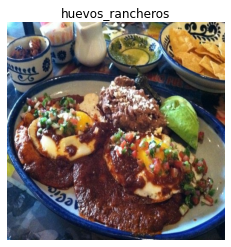

In [12]:
# Import matplotlib
import matplotlib.pyplot as plt

# Use matplotlib to show image
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add the class name in str format as the title
plt.axis(False)

## Create preprocessing functions for our data

What we know about our data:
* uses `uint8` datatype
* Comprised of tensors of different sizes
* Not scaled/normalized (pixel values between 0 and 255)

What deep learning models prefer:
* Data in `float32` dtype (or `float16` and `float32` for mixed precision)
* Tensors to be of the same size
* Scaled (values between 0 and 1)

Therefore, let's use these points to create a preprocessing function.

**Note:** As we are going to use EfficientNetB0 pretrained model, we are not required to rescale our data as the model has scalling architectures bulit-in.


In [13]:
# Import tensorflow
import tensorflow as tf

In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' to 'float32' 
  and reshapes the image to [img_shape, img_shape, 3]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label # Return (float32_image, label)

In [15]:
# Preprocess a single sample image and check the outputs 
preprocessed_img = preprocess_img(image, label)[0]

# Check the tensor output, image shape, and image datatype of the image before preprocessing
print(f"Image before preprocessing:\n{image[:2]}...\nShape: {image.shape},\nDatatype: {image.dtype}\n")

# Check the tensor output, image shape, and image datatype of the image after preprocessing
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batching and preparing our dataset

In [16]:
# Map the preprocessing function to the training dataset
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # Use of AUTOTUNE to improve performance

# Shuffle train_data and turn it into batches and prefetch it (to improve performance)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map the preprocessing function to the testing dataset and put it into batches
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> In the previous cells, we have used [best practices in dealing with data](https://www.tensorflow.org/guide/data_performance#best_practice_summary) to best utalize the CPU and GPU.

>Prefetching meaning that while the GPU is doing its computing work, the CPU is already starting at the next task.

> The AUTOTUNE here means the use of multithreding, which means that we are using as many CPUs as possible to finish the tasks.

## Create modelling callbacks

We are going to create a couple of callbacks to help us while our model trains:
* **TensorBoard callback** to log training results (so we can visualize them later if need be)

* **ModelCheckpoint callback** to save our model progress after feature extraction

In [18]:
# Create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [19]:
# Create ModelCheckpoint callback to save a model's weights during trainig
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision

Mixed precision itlizes a combination of float32 and float16 data types to speed up model performance.

In [20]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [21]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Bulid feature extraction model

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # As we are trying to create a feature extraction model

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # Freeze the model as we are trying to create a feature extraction model
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [23]:
# Get summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer data type policies (are we using mixed precision?)

In [24]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name,"-", layer.trainable,"-", layer.dtype,"-", layer.dtype_policy)

input_layer - True - float32 - <Policy "float32">
efficientnetb0 - False - float32 - <Policy "mixed_float16">
global_average_pooling2d - True - float32 - <Policy "mixed_float16">
dense - True - float32 - <Policy "mixed_float16">
softmax_float32 - True - float32 - <Policy "float32">


* **`layer.name`:** the name of the layer.
* **`layer.trainable`:** is the layer trainable or not?
* **`layer.dtype`:** the data type the layers store its variables in
* **`layer.dtype_policy`:** the data type policy a layer computes on its variables with 

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers:
  print(layer.name,"-", layer.trainable,"-", layer.dtype,"-", layer.dtype_policy)

## Fit the feature extraction model


In [28]:
# Fit the feature extractiob model with callbacks
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=(len(train_data)),
                                       validation_data=test_data,
                                       validation_steps = int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                              experiment_name="Food101-Feature-Extraction"),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/Food101-Feature-Extraction/20220923-065529
Epoch 1/3
2368/2368 [==============================] - 216s 81ms/step - loss: 2.3280 - accuracy: 0.4639 - val_loss: 1.2338 - val_accuracy: 0.6748
Epoch 2/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.3196 - accuracy: 0.6600 - val_loss: 1.1295 - val_accuracy: 0.6994
Epoch 3/3
2368/2368 [==============================] - 184s 77ms/step - loss: 1.1450 - accuracy: 0.7024 - val_loss: 1.0976 - val_accuracy: 0.7100


In [26]:
# Load weights (use if google collab run out of RAM)
model.load_weights(checkpoint_path)

## Evaluate the model

In [29]:
# Evalaute model on whole dataset
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model       

790/790 [==============================] - 67s 68ms/step - loss: 1.0937 - accuracy: 0.7050


[1.0937378406524658, 0.7050297260284424]

## Prepare for fine-tuning
The feature extraction model has showed great score, but have not yet beaten the DeepFood Paper, therefore, where are going to use fine-tuning as it works well with big datasets

In [30]:
# Check which layers are trainable
for layer in model.layers:
  print(layer.name," - ", layer.trainable)

input_layer  -  True
efficientnetb0  -  False
global_average_pooling2d  -  True
dense  -  True
softmax_float32  -  True


It seems like all layers are trainable excepts for base model layer, therefore, we are going to unfreeze it so that the weights can improve overtime (we are unfreezing the entire dataset solely for the reason that it is huge, otherwise, we would have only unfrooze some layers at the top of the base model)

In [31]:
for layer in model.layers:
  layer.trainable = True
  print(layer.name," - ", layer.trainable)

input_layer  -  True
efficientnetb0  -  True
global_average_pooling2d  -  True
dense  -  True
softmax_float32  -  True


In [35]:
for layer in model.layers[1].layers[:15]:
  print(layer.name," - ", layer.trainable, " - ", layer.dtype_policy)

input_1  -  True  -  <Policy "float32">
rescaling  -  True  -  <Policy "mixed_float16">
normalization  -  True  -  <Policy "float32">
stem_conv_pad  -  True  -  <Policy "mixed_float16">
stem_conv  -  True  -  <Policy "mixed_float16">
stem_bn  -  True  -  <Policy "mixed_float16">
stem_activation  -  True  -  <Policy "mixed_float16">
block1a_dwconv  -  True  -  <Policy "mixed_float16">
block1a_bn  -  True  -  <Policy "mixed_float16">
block1a_activation  -  True  -  <Policy "mixed_float16">
block1a_se_squeeze  -  True  -  <Policy "mixed_float16">
block1a_se_reshape  -  True  -  <Policy "mixed_float16">
block1a_se_reduce  -  True  -  <Policy "mixed_float16">
block1a_se_expand  -  True  -  <Policy "mixed_float16">
block1a_se_excite  -  True  -  <Policy "mixed_float16">


Looking good, all the layers are unfroozen, and the mixed precison is working just fine

## Create callbacks


### Create EarlyStopping callback

When we fit the model, we would want it to train it for as long as it is improving and not overfitting. To do that we can use the `EarlyStopping` callback.

In [39]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3) # number of epochs with no improvment before stopping

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

### Create ReduceLROnPlateau Callback

The ReduceLROnPlateau is a callback that adjust the learning rate of the optimizer based on the outcome of a specefic metric.

In [36]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Re-Compile the model

In [37]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.0001), # lower learning rate because we are fine-tuning
                        metrics=["accuracy"])

In [40]:
# Start to fine-tune (all layers)
history_fine_tune = model.fit(train_data,
                    epochs=100, # fine-tune for a maximum of 100 epochs
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                    callbacks=[create_tensorboard_callback("training_logs", "Food101-Fine-Tuning"),
                              model_checkpoint,
                              early_stopping,
                              reduce_lr])

Saving TensorBoard log files to: training_logs/Food101-Fine-Tuning/20220923-072756
Epoch 1/100
2368/2368 [==============================] - 309s 125ms/step - loss: 0.9771 - accuracy: 0.7397 - val_loss: 0.8162 - val_accuracy: 0.7770
Epoch 2/100
2368/2368 [==============================] - 294s 123ms/step - loss: 0.5965 - accuracy: 0.8352 - val_loss: 0.7995 - val_accuracy: 0.7879
Epoch 3/100
2368/2368 [==============================] - 295s 124ms/step - loss: 0.3327 - accuracy: 0.9074 - val_loss: 0.8303 - val_accuracy: 0.7850
Epoch 4/100
2368/2368 [==============================] - 293s 123ms/step - loss: 0.1690 - accuracy: 0.9510 - val_loss: 0.9875 - val_accuracy: 0.7850

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 294s 124ms/step - loss: 0.0489 - accuracy: 0.9872 - val_loss: 1.0485 - val_accuracy: 0.8051


## Evaluate model

After fine-tuning, it is time to see whether we have achieved our results or not in beating the DeepFood paper (77.4% top-1 accuracy).

In [45]:
model.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.0519 - accuracy: 0.7992


[1.0518946647644043, 0.7992079257965088]

As we got a higher accuracy (79.92 accuracy), we can say that we have beaten teh DeepFood Paper.

> Now, let's viualize the evaluation, by predicted custom images

In [46]:
# Create a function to read images from filepath
def load_and_prep_image(filename):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [224, 224])
  
  return img

In [58]:
def pred_and_plot(filename, model=model):
  # load the image
  img = load_and_prep_image(filename)

  # Make prediction
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);

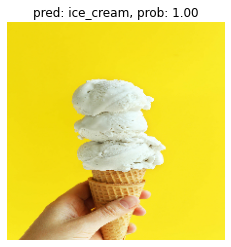

In [57]:
pred_and_plot("ice-cream.jpg")

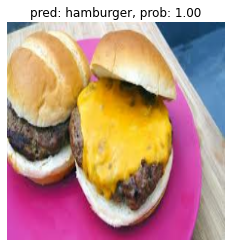

In [59]:
pred_and_plot('burger.jpg')